# DP - Car Rental Problem

Policy converged.


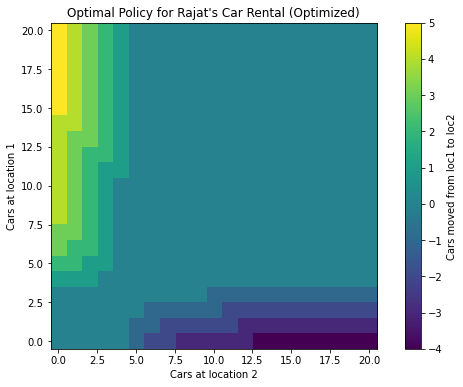

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import poisson

# Parameters
max_cars = 20
max_move_cars = 5
rental_reward = 10
move_cost = 2
discount = 0.9

# Poisson rates
lambda_req1, lambda_req2 = 3, 4
lambda_ret1, lambda_ret2 = 3, 2
poisson_upper_bound = 6
poisson_threshold = 1e-3

# Cache Poisson probabilities
poisson_cache = dict()
def get_poisson_probs(lmbda):
    probs = []
    for n in range(poisson_upper_bound):
        p = poisson.pmf(n, lmbda)
        if p > poisson_threshold:
            probs.append((n, p))
    return probs

poisson_reqs1 = get_poisson_probs(lambda_req1)
poisson_reqs2 = get_poisson_probs(lambda_req2)
poisson_rets1 = get_poisson_probs(lambda_ret1)
poisson_rets2 = get_poisson_probs(lambda_ret2)

# Initialize value and policy
value = np.zeros((max_cars + 1, max_cars + 1))
policy = np.zeros_like(value, dtype=int)

# Transition cache: (state, action) -> list of (probability, next_state, reward)
transition_cache = dict()

def get_transitions(state, action):
    if (state, action) in transition_cache:
        return transition_cache[(state, action)]

    cars1 = min(state[0] - action, max_cars)
    cars2 = min(state[1] + action, max_cars)
    transitions = []

    for req1, p_req1 in poisson_reqs1:
        for req2, p_req2 in poisson_reqs2:
            real_rent1 = min(cars1, req1)
            real_rent2 = min(cars2, req2)
            reward = rental_reward * (real_rent1 + real_rent2)

            cars1_left = cars1 - real_rent1
            cars2_left = cars2 - real_rent2

            for ret1, p_ret1 in poisson_rets1:
                for ret2, p_ret2 in poisson_rets2:
                    new_cars1 = min(cars1_left + ret1, max_cars)
                    new_cars2 = min(cars2_left + ret2, max_cars)
                    prob = p_req1 * p_req2 * p_ret1 * p_ret2
                    transitions.append((prob, (new_cars1, new_cars2), reward))

    transition_cache[(state, action)] = transitions
    return transitions

# Policy Iteration
while True:
    # --- Policy Evaluation ---
    theta = 1e-3
    while True:
        delta = 0
        for i in range(max_cars + 1):
            for j in range(max_cars + 1):
                v = value[i, j]
                new_v = -move_cost * abs(policy[i, j])
                for prob, (ni, nj), reward in get_transitions((i, j), policy[i, j]):
                    new_v += prob * (reward + discount * value[ni, nj])
                value[i, j] = new_v
                delta = max(delta, abs(v - new_v))
        if delta < theta:
            break

    # --- Policy Improvement ---
    policy_stable = True
    for i in range(max_cars + 1):
        for j in range(max_cars + 1):
            old_action = policy[i, j]
            action_values = []
            possible_actions = range(-min(j, max_move_cars), min(i, max_move_cars) + 1)
            for action in possible_actions:
                expected = -move_cost * abs(action)
                for prob, (ni, nj), reward in get_transitions((i, j), action):
                    expected += prob * (reward + discount * value[ni, nj])
                action_values.append(expected)
            best_action = list(possible_actions)[np.argmax(action_values)]
            policy[i, j] = best_action
            if old_action != best_action:
                policy_stable = False

    if policy_stable:
        print("Policy converged.")
        break

# Plot the final policy
plt.figure(figsize=(10, 6))
plt.imshow(policy, origin='lower')
plt.colorbar(label='Cars moved from loc1 to loc2')
plt.title('Optimal Policy for Rajat\'s Car Rental (Optimized)')
plt.xlabel('Cars at location 2')
plt.ylabel('Cars at location 1')
plt.show()
